# Introduction to single-cell multi-view profiler (scMVP)
In this introductory tutorial, we present the different tasks of a scMVP workflow
1. Loading the multi-omics data
2. Training the multi-view model
3. Retrieving the common latent space and imputed multi-omics values
4. Perform cell clustering and differential expression 
5. Visualize the common latent space and clustering with umap
6. The differential gene cluster identification

In [3]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scMVP.dataset import SciCarDemo
from scMVP.models import VAE
from scMVP.inference import UnsupervisedTrainer
from scMVP.inference import MultiPosterior, MultiTrainer
import torch
from scMVP.models.multi_vae import Multi_VAE

## Visualizing the latent space with scanpy
import scanpy as sc
import anndata


## Loading data

 loading the sci-CAR cell line dataset described in Junyue Cao et al. (2018).

* Junyue Cao, et al. "Joint profiling of chromatin accessibility and gene 
expression in thousands of single cells." Science 361.6409 (2018): 1380-1385. 

In [4]:
def allow_mmvae_for_test():
    print("Testing the basic tutorial scMVP")

test_mode = False
# define the repository for trained models
model_path = "dataset/pretrain_model/"
n_epochs_all = None
show_plot = True

dataset=SciCarDemo(dataset_name="CellLineMixture",data_path="dataset/sci_car/")

[2021-01-22 11:12:19,791] INFO - scMVP.dataset.scMVP_dataloader | Preprocessing joint profiling dataset.
[2021-01-22 11:12:35,464] INFO - scMVP.dataset.scMVP_dataloader | Finished preprocessing dataset
[2021-01-22 11:12:37,189] INFO - scMVP.dataset.dataset | Remapping batch_indices to [0,N]
[2021-01-22 11:12:37,191] INFO - scMVP.dataset.dataset | Remapping labels to [0,N]
[2021-01-22 11:12:38,979] INFO - scMVP.dataset.dataset | Computing the library size for the new data
[2021-01-22 11:12:39,833] INFO - scMVP.dataset.dataset | Downsampled from 4825 to 4825 cells


## data filtering 

In [5]:
def filter_dataset(dataset):
    high_count_genes = (dataset.X > 0).sum(axis=0).ravel() > 0.01 * dataset.X.shape[0]
    dataset.update_genes(high_count_genes)
    dataset.subsample_genes(new_n_genes=10000)
    
    high_gene_count_cells = (dataset.X > 0).sum(axis=1).ravel() > 50
    #high_atac_cells = dataset.atac_expression.sum(axis=1) >= np.percentile(dataset.atac_expression.sum(axis=1), 10)
    high_atac_cells = dataset.atac_expression.sum(axis=1) >= np.percentile(dataset.atac_expression.sum(axis=1), 1)
    inds_to_keep = np.logical_and(high_gene_count_cells, high_atac_cells)
    dataset.update_cells(inds_to_keep)
    return dataset, inds_to_keep

if test_mode is False:
    dataset, inds_to_keep = filter_dataset(dataset)


[2021-01-22 11:13:25,117] INFO - scMVP.dataset.dataset | Downsampling from 113153 to 20403 genes
[2021-01-22 11:13:25,774] INFO - scMVP.dataset.dataset | Computing the library size for the new data
[2021-01-22 11:13:26,115] INFO - scMVP.dataset.dataset | Filtering non-expressing cells.
[2021-01-22 11:13:27,464] INFO - scMVP.dataset.dataset | Computing the library size for the new data
[2021-01-22 11:13:27,609] INFO - scMVP.dataset.dataset | Downsampled from 4825 to 4825 cells
[2021-01-22 11:13:29,409] INFO - scMVP.dataset.dataset | Downsampling from 20403 to 10000 genes
[2021-01-22 11:13:29,859] INFO - scMVP.dataset.dataset | Computing the library size for the new data
[2021-01-22 11:13:30,027] INFO - scMVP.dataset.dataset | Filtering non-expressing cells.
[2021-01-22 11:13:31,132] INFO - scMVP.dataset.dataset | Computing the library size for the new data
[2021-01-22 11:13:31,205] INFO - scMVP.dataset.dataset | Downsampled from 4825 to 4825 cells
[2021-01-22 11:13:32,732] INFO - scMVP.

* __n_epochs__: Maximum number of epochs to train the model. If the likelihood change is small than a set threshold training will stop automatically. 
* __lr__: learning rate. Set to 0.001 here. 
* __use_batches__: If the value of true than batch information is used in the training. Here it is set to false because the cortex data only contains one batch. 
* __use_cuda__: Set to true to use CUDA (GPU required) 
* __n_centroids__: Set the number of cell types
* __n_alfa__: Set the weight of KL loss

In [6]:
n_epochs = 30 if n_epochs_all is None else n_epochs_all
lr = 1e-3
use_batches = False
use_cuda = False # True if using GPU
n_centroids = 5
n_alfa = 1.0

## Pre-training
runing pre-train vae to initialize the Gaussian Mixture Model

<All keys matched successfully>

VAE(
  (z_encoder): Encoder(
    (encoder): FCLayers(
      (fc_layers): Sequential(
        (Layer 0): Sequential(
          (0): Linear(in_features=10000, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (mean_encoder): Linear(in_features=128, out_features=10, bias=True)
    (var_encoder): Linear(in_features=128, out_features=10, bias=True)
  )
  (l_encoder): Encoder(
    (encoder): FCLayers(
      (fc_layers): Sequential(
        (Layer 0): Sequential(
          (0): Linear(in_features=10000, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (mean_encoder): Linear(in_features=128, out_features=1, bias=True)
    (var_encoder): Linear(in_features=1

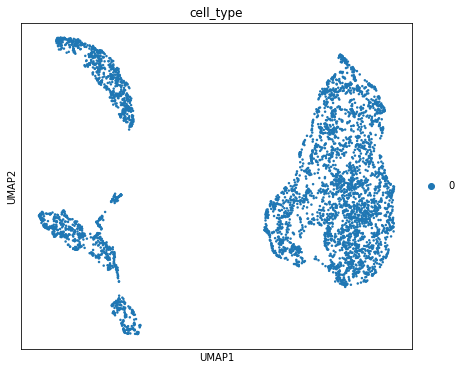

In [10]:
pre_vae = VAE(dataset.nb_genes, n_batch=256)
pre_trainer = UnsupervisedTrainer(
    pre_vae,
    dataset,
    train_size=0.75,
    use_cuda=use_cuda,
    frequency=5
)
is_test_pragram = False
if is_test_pragram:
    pre_trainer.train(n_epochs=n_epochs, lr=lr)
    torch.save(pre_trainer.model.state_dict(), '%s/GMM_pre_trainer.pkl' % model_path)

if os.path.isfile('%s/GMM_pre_trainer.pkl' % model_path):
    pre_trainer.model.load_state_dict(torch.load('%s/GMM_pre_trainer.pkl' % model_path))
    pre_trainer.model.eval()
else:
    #pre_trainer.model.init_gmm_params(dataset)
    pre_trainer.train(n_epochs=n_epochs, lr=lr)
    torch.save(pre_trainer.model.state_dict(), '%s/GMM_pre_trainer.pkl' % model_path)

# pretrainer_posterior:
full = pre_trainer.create_posterior(pre_trainer.model, dataset, indices=np.arange(len(dataset)))
latent, batch_indices, labels = full.sequential().get_latent()
batch_indices = batch_indices.ravel()
imputed_values = full.sequential().imputation()

# visulization
prior_adata = anndata.AnnData(X=dataset.X)
prior_adata.obsm["X_multi_vi"] = latent
prior_adata.obs['cell_type'] = pd.Categorical(labels.astype(int))
sc.pp.neighbors(prior_adata, use_rep="X_multi_vi", n_neighbors=15)
sc.tl.umap(prior_adata, min_dist=0.1)
fig, ax = plt.subplots(figsize=(7, 6))
sc.pl.umap(prior_adata, color=["cell_type"], ax=ax, show=show_plot)

# Training scMVP
We now create the scMVP model and the trainer object.

If a pre-trained model already exist in the path, then load the same model rather than re-training it. This is particularly useful for large datasets.

In [13]:
multi_vae = Multi_VAE(dataset.nb_genes, len(dataset.atac_names), n_batch=256, n_centroids=n_centroids, n_alfa = n_alfa, mode="mm-vae") # should provide ATAC num, alfa, mode and loss type
trainer = MultiTrainer(
    multi_vae,
    dataset,
    train_size=0.75,
    use_cuda=use_cuda,
    frequency=5,
)

clust_index_gmm = trainer.model.init_gmm_params(latent)

is_test_pragram = False
if is_test_pragram:
    trainer.train(n_epochs=n_epochs, lr=lr)
    torch.save(trainer.model.state_dict(), '%s/scMVP_multi_vae.pkl' % model_path)
if os.path.isfile('%s/scMVP_multi_vae.pkl' % model_path):
    trainer.model.load_state_dict(torch.load('%s/scMVP_multi_vae.pkl' % model_path))
    trainer.model.eval()
else:
    trainer.train(n_epochs=n_epochs, lr=lr)
    torch.save(trainer.model.state_dict(), '%s/scMVP_multi_vae.pkl' % model_path)

training:   0%|          | 0/30 [00:00<?, ?it/s]kld_qz_pz = 73.714073,kld_qz_rna = 1.510934,kld_qz_atac = 1.032740,kl_divergence = 147.798920,reconst_loss_rna = 29492.292969,        reconst_loss_atac = 4949.519531, mu=-0.045930, sigma=0.622173
reconst_loss = 34444.332031,kl_divergence_local = 147.798920,kl_weight = 1.000000,loss = 34592.125000
tensor(34592.1250, grad_fn=<DivBackward0>)
kld_qz_pz = 67.315475,kld_qz_rna = 3.161268,kld_qz_atac = 2.133896,kl_divergence = 158.603943,reconst_loss_rna = 21327.707031,        reconst_loss_atac = 4933.108887, mu=-0.045868, sigma=0.623145
reconst_loss = 26263.335938,kl_divergence_local = 158.603943,kl_weight = 1.000000,loss = 26421.937500
tensor(26421.9375, grad_fn=<DivBackward0>)
kld_qz_pz = 62.858459,kld_qz_rna = 2.084626,kld_qz_atac = 1.316497,kl_divergence = 144.368896,reconst_loss_rna = 20486.271484,        reconst_loss_atac = 4944.648438, mu=-0.045817, sigma=0.624069
reconst_loss = 25433.435547,kl_divergence_local = 144.368896,kl_weight = 1

kld_qz_pz = 39.471676,kld_qz_rna = 4.266266,kld_qz_atac = 5.089496,kl_divergence = 122.377075,reconst_loss_rna = 15139.991211,        reconst_loss_atac = 4628.184570, mu=-0.045563, sigma=0.637824
reconst_loss = 19770.667969,kl_divergence_local = 122.377075,kl_weight = 1.000000,loss = 19893.044922
tensor(19893.0449, grad_fn=<DivBackward0>)
kld_qz_pz = 39.160870,kld_qz_rna = 4.380609,kld_qz_atac = 5.375347,kl_divergence = 122.487244,reconst_loss_rna = 15424.606445,        reconst_loss_atac = 4627.265137, mu=-0.045525, sigma=0.638338
reconst_loss = 20054.367188,kl_divergence_local = 122.487244,kl_weight = 1.000000,loss = 20176.851562
tensor(20176.8516, grad_fn=<DivBackward0>)
kld_qz_pz = 39.062149,kld_qz_rna = 4.098982,kld_qz_atac = 4.722000,kl_divergence = 122.989464,reconst_loss_rna = 15514.701172,        reconst_loss_atac = 4586.359863, mu=-0.045485, sigma=0.638844
reconst_loss = 20103.552734,kl_divergence_local = 122.989464,kl_weight = 1.000000,loss = 20226.542969
tensor(20226.5430, g

kld_qz_pz = 34.210400,kld_qz_rna = 5.188465,kld_qz_atac = 6.336053,kl_divergence = 114.808334,reconst_loss_rna = 14179.220703,        reconst_loss_atac = 4047.923828, mu=-0.045050, sigma=0.649161
reconst_loss = 18229.619141,kl_divergence_local = 114.808334,kl_weight = 1.000000,loss = 18344.425781
tensor(18344.4258, grad_fn=<DivBackward0>)
kld_qz_pz = 34.439857,kld_qz_rna = 5.908319,kld_qz_atac = 7.037590,kl_divergence = 112.546555,reconst_loss_rna = 14729.958984,        reconst_loss_atac = 4010.158691, mu=-0.045022, sigma=0.649650
reconst_loss = 18742.591797,kl_divergence_local = 112.546555,kl_weight = 1.000000,loss = 18855.140625
tensor(18855.1406, grad_fn=<DivBackward0>)
kld_qz_pz = 36.822815,kld_qz_rna = 5.881962,kld_qz_atac = 6.685833,kl_divergence = 115.619881,reconst_loss_rna = 14657.893555,        reconst_loss_atac = 3968.963379, mu=-0.044989, sigma=0.650135
reconst_loss = 18629.330078,kl_divergence_local = 115.619881,kl_weight = 1.000000,loss = 18744.951172
tensor(18744.9512, g

kld_qz_pz = 25.140648,kld_qz_rna = 5.155784,kld_qz_atac = 5.639886,kl_divergence = 87.603020,reconst_loss_rna = 11275.276367,        reconst_loss_atac = 2985.661377, mu=-0.044475, sigma=0.659431
reconst_loss = 14263.399414,kl_divergence_local = 87.603020,kl_weight = 1.000000,loss = 14351.002930
tensor(14351.0029, grad_fn=<DivBackward0>)
kld_qz_pz = 24.601429,kld_qz_rna = 4.864874,kld_qz_atac = 5.422428,kl_divergence = 87.336121,reconst_loss_rna = 11163.498047,        reconst_loss_atac = 2950.333496, mu=-0.044490, sigma=0.659789
reconst_loss = 14116.290039,kl_divergence_local = 87.336121,kl_weight = 1.000000,loss = 14203.625000
tensor(14203.6250, grad_fn=<DivBackward0>)
kld_qz_pz = 28.089426,kld_qz_rna = 5.288661,kld_qz_atac = 5.815024,kl_divergence = 97.721191,reconst_loss_rna = 12709.906250,        reconst_loss_atac = 2892.408447, mu=-0.044499, sigma=0.660143
reconst_loss = 15604.772461,kl_divergence_local = 97.721191,kl_weight = 1.000000,loss = 15702.494141
tensor(15702.4941, grad_fn

kld_qz_pz = 25.601507,kld_qz_rna = 5.802223,kld_qz_atac = 6.628749,kl_divergence = 92.651840,reconst_loss_rna = 10435.769531,        reconst_loss_atac = 2366.327148, mu=-0.044468, sigma=0.663685
reconst_loss = 12804.541992,kl_divergence_local = 92.651840,kl_weight = 1.000000,loss = 12897.193359
tensor(12897.1934, grad_fn=<DivBackward0>)
kld_qz_pz = 26.210735,kld_qz_rna = 6.284155,kld_qz_atac = 7.667701,kl_divergence = 87.022339,reconst_loss_rna = 9407.957031,        reconst_loss_atac = 2283.997314, mu=-0.044444, sigma=0.664041
reconst_loss = 11694.386719,kl_divergence_local = 87.022339,kl_weight = 1.000000,loss = 11781.410156
tensor(11781.4102, grad_fn=<DivBackward0>)
kld_qz_pz = 25.661743,kld_qz_rna = 6.033502,kld_qz_atac = 6.562116,kl_divergence = 97.529655,reconst_loss_rna = 10334.310547,        reconst_loss_atac = 2242.289307, mu=-0.044417, sigma=0.664395
reconst_loss = 12579.048828,kl_divergence_local = 97.529655,kl_weight = 1.000000,loss = 12676.576172
tensor(12676.5762, grad_fn=

kld_qz_pz = 21.213566,kld_qz_rna = 5.611697,kld_qz_atac = 6.728718,kl_divergence = 71.234291,reconst_loss_rna = 7385.780762,        reconst_loss_atac = 1206.287109, mu=-0.044021, sigma=0.671889
reconst_loss = 8594.502930,kl_divergence_local = 71.234291,kl_weight = 1.000000,loss = 8665.736328
tensor(8665.7363, grad_fn=<DivBackward0>)
kld_qz_pz = 21.099285,kld_qz_rna = 6.228272,kld_qz_atac = 7.078245,kl_divergence = 74.847008,reconst_loss_rna = 8080.278320,        reconst_loss_atac = 1145.272949, mu=-0.044029, sigma=0.672213
reconst_loss = 9227.980469,kl_divergence_local = 74.847008,kl_weight = 1.000000,loss = 9302.827148
tensor(9302.8271, grad_fn=<DivBackward0>)
kld_qz_pz = 21.691921,kld_qz_rna = 5.777784,kld_qz_atac = 6.722476,kl_divergence = 88.114166,reconst_loss_rna = 7889.999023,        reconst_loss_atac = 1154.633301, mu=-0.044037, sigma=0.672528
reconst_loss = 9047.071289,kl_divergence_local = 88.114166,kl_weight = 1.000000,loss = 9135.183594
tensor(9135.1836, grad_fn=<DivBackwar

kld_qz_pz = 19.263865,kld_qz_rna = 6.480699,kld_qz_atac = 6.974259,kl_divergence = 64.233208,reconst_loss_rna = 5431.721680,        reconst_loss_atac = 647.642090, mu=-0.044137, sigma=0.678892
reconst_loss = 6081.788574,kl_divergence_local = 64.233208,kl_weight = 1.000000,loss = 6146.022461
tensor(6146.0225, grad_fn=<DivBackward0>)
kld_qz_pz = 19.975872,kld_qz_rna = 6.726002,kld_qz_atac = 7.405551,kl_divergence = 60.794247,reconst_loss_rna = 5441.012207,        reconst_loss_atac = 682.183105, mu=-0.044136, sigma=0.679140
reconst_loss = 6125.603516,kl_divergence_local = 60.794247,kl_weight = 1.000000,loss = 6186.397461
tensor(6186.3975, grad_fn=<DivBackward0>)
training:  30%|███       | 9/30 [02:02<04:39, 13.33s/it]kld_qz_pz = 19.734230,kld_qz_rna = 5.939538,kld_qz_atac = 6.236986,kl_divergence = 62.429718,reconst_loss_rna = 5857.792969,        reconst_loss_atac = 626.210083, mu=-0.044128, sigma=0.679391
reconst_loss = 6486.426758,kl_divergence_local = 62.429718,kl_weight = 1.000000,los

kld_qz_pz = 19.392912,kld_qz_rna = 9.526288,kld_qz_atac = 230.946823,kl_divergence = 2233.512695,reconst_loss_rna = 16340.749023,        reconst_loss_atac = 741.528076, mu=-0.044216, sigma=0.683259
kld_qz_pz = 22.370552,kld_qz_rna = 11.062110,kld_qz_atac = 231.261856,kl_divergence = 2405.550781,reconst_loss_rna = 15368.195312,        reconst_loss_atac = 717.787720, mu=-0.044216, sigma=0.683259
kld_qz_pz = 21.413914,kld_qz_rna = 9.701295,kld_qz_atac = 225.256378,kl_divergence = 2449.938965,reconst_loss_rna = 15890.675781,        reconst_loss_atac = 734.782776, mu=-0.044216, sigma=0.683259
kld_qz_pz = 21.531113,kld_qz_rna = 10.019417,kld_qz_atac = 218.172821,kl_divergence = 2283.108887,reconst_loss_rna = 15886.400391,        reconst_loss_atac = 779.172852, mu=-0.044216, sigma=0.683259
kld_qz_pz = 24.163204,kld_qz_rna = 10.503649,kld_qz_atac = 220.915497,kl_divergence = 2719.900635,reconst_loss_rna = 15884.273438,        reconst_loss_atac = 736.091675, mu=-0.044216, sigma=0.683259
kld_qz_

kld_qz_pz = 18.790592,kld_qz_rna = 6.135923,kld_qz_atac = 6.750444,kl_divergence = 61.096535,reconst_loss_rna = 4973.654785,        reconst_loss_atac = 445.041138, mu=-0.044395, sigma=0.688463
reconst_loss = 5421.123535,kl_divergence_local = 61.096535,kl_weight = 1.000000,loss = 5482.220703
tensor(5482.2207, grad_fn=<DivBackward0>)
kld_qz_pz = 17.910406,kld_qz_rna = 5.938950,kld_qz_atac = 6.326340,kl_divergence = 53.061134,reconst_loss_rna = 4890.466797,        reconst_loss_atac = 510.595520, mu=-0.044408, sigma=0.688701
reconst_loss = 5403.476562,kl_divergence_local = 53.061134,kl_weight = 1.000000,loss = 5456.537598
tensor(5456.5376, grad_fn=<DivBackward0>)
kld_qz_pz = 16.886190,kld_qz_rna = 5.769114,kld_qz_atac = 6.573006,kl_divergence = 54.275986,reconst_loss_rna = 5321.311035,        reconst_loss_atac = 565.110657, mu=-0.044419, sigma=0.688939
reconst_loss = 5888.832031,kl_divergence_local = 54.275986,kl_weight = 1.000000,loss = 5943.107910
tensor(5943.1079, grad_fn=<DivBackward0>

kld_qz_pz = 14.992899,kld_qz_rna = 5.645289,kld_qz_atac = 6.110207,kl_divergence = 49.091011,reconst_loss_rna = 4708.293945,        reconst_loss_atac = 507.362671, mu=-0.044401, sigma=0.694468
reconst_loss = 5218.065430,kl_divergence_local = 49.091011,kl_weight = 1.000000,loss = 5267.157227
tensor(5267.1572, grad_fn=<DivBackward0>)
kld_qz_pz = 14.640295,kld_qz_rna = 5.619419,kld_qz_atac = 5.842284,kl_divergence = 67.963493,reconst_loss_rna = 5277.741211,        reconst_loss_atac = 491.379517, mu=-0.044398, sigma=0.694689
reconst_loss = 5771.526367,kl_divergence_local = 67.963493,kl_weight = 1.000000,loss = 5839.490723
tensor(5839.4907, grad_fn=<DivBackward0>)
kld_qz_pz = 14.284971,kld_qz_rna = 5.856553,kld_qz_atac = 6.173148,kl_divergence = 55.400921,reconst_loss_rna = 5041.152344,        reconst_loss_atac = 474.308685, mu=-0.044402, sigma=0.694905
reconst_loss = 5517.875488,kl_divergence_local = 55.400921,kl_weight = 1.000000,loss = 5573.276855
tensor(5573.2769, grad_fn=<DivBackward0>

kld_qz_pz = 16.743769,kld_qz_rna = 5.268613,kld_qz_atac = 6.267423,kl_divergence = 54.836437,reconst_loss_rna = 4689.357910,        reconst_loss_atac = 441.749084, mu=-0.044285, sigma=0.700016
reconst_loss = 5133.512695,kl_divergence_local = 54.836437,kl_weight = 1.000000,loss = 5188.349609
tensor(5188.3496, grad_fn=<DivBackward0>)
kld_qz_pz = 16.382301,kld_qz_rna = 5.232055,kld_qz_atac = 6.309724,kl_divergence = 48.976044,reconst_loss_rna = 4838.124023,        reconst_loss_atac = 518.452148, mu=-0.044272, sigma=0.700282
reconst_loss = 5358.979004,kl_divergence_local = 48.976044,kl_weight = 1.000000,loss = 5407.954590
tensor(5407.9546, grad_fn=<DivBackward0>)
kld_qz_pz = 15.795335,kld_qz_rna = 5.298869,kld_qz_atac = 5.978780,kl_divergence = 53.568844,reconst_loss_rna = 4616.384277,        reconst_loss_atac = 424.075073, mu=-0.044260, sigma=0.700547
reconst_loss = 5042.862793,kl_divergence_local = 53.568844,kl_weight = 1.000000,loss = 5096.431152
tensor(5096.4312, grad_fn=<DivBackward0>

kld_qz_pz = 14.968524,kld_qz_rna = 4.507235,kld_qz_atac = 5.642512,kl_divergence = 44.388737,reconst_loss_rna = 4529.757812,        reconst_loss_atac = 425.973816, mu=-0.044359, sigma=0.703189
reconst_loss = 4958.130859,kl_divergence_local = 44.388737,kl_weight = 1.000000,loss = 5002.520020
tensor(5002.5200, grad_fn=<DivBackward0>)
kld_qz_pz = 15.460773,kld_qz_rna = 4.791403,kld_qz_atac = 5.839913,kl_divergence = 44.889053,reconst_loss_rna = 4740.519043,        reconst_loss_atac = 409.846069, mu=-0.044372, sigma=0.703418
reconst_loss = 5152.765137,kl_divergence_local = 44.889053,kl_weight = 1.000000,loss = 5197.654297
tensor(5197.6543, grad_fn=<DivBackward0>)
kld_qz_pz = 15.801022,kld_qz_rna = 4.207926,kld_qz_atac = 5.474847,kl_divergence = 44.363991,reconst_loss_rna = 4861.800781,        reconst_loss_atac = 459.410492, mu=-0.044385, sigma=0.703644
reconst_loss = 5323.615723,kl_divergence_local = 44.363991,kl_weight = 1.000000,loss = 5367.979980
tensor(5367.9800, grad_fn=<DivBackward0>

kld_qz_pz = 10.871006,kld_qz_rna = 4.493523,kld_qz_atac = 4.973234,kl_divergence = 41.986553,reconst_loss_rna = 4467.338867,        reconst_loss_atac = 394.190857, mu=-0.044098, sigma=0.708362
reconst_loss = 4863.927246,kl_divergence_local = 41.986553,kl_weight = 1.000000,loss = 4905.914551
tensor(4905.9146, grad_fn=<DivBackward0>)
kld_qz_pz = 11.387164,kld_qz_rna = 4.307494,kld_qz_atac = 4.845936,kl_divergence = 44.228443,reconst_loss_rna = 4842.837891,        reconst_loss_atac = 464.423706, mu=-0.044073, sigma=0.708531
reconst_loss = 5309.651367,kl_divergence_local = 44.228443,kl_weight = 1.000000,loss = 5353.879395
tensor(5353.8794, grad_fn=<DivBackward0>)
kld_qz_pz = 9.319868,kld_qz_rna = 4.383785,kld_qz_atac = 5.157407,kl_divergence = 39.200222,reconst_loss_rna = 4648.435059,        reconst_loss_atac = 400.630066, mu=-0.044053, sigma=0.708686
reconst_loss = 5051.450684,kl_divergence_local = 39.200222,kl_weight = 1.000000,loss = 5090.651367
tensor(5090.6514, grad_fn=<DivBackward0>)

kld_qz_pz = 8.601656,kld_qz_rna = 5.236405,kld_qz_atac = 5.397165,kl_divergence = 40.948727,reconst_loss_rna = 4594.408691,        reconst_loss_atac = 425.991241, mu=-0.043208, sigma=0.711519
reconst_loss = 5022.782715,kl_divergence_local = 40.948727,kl_weight = 1.000000,loss = 5063.731445
tensor(5063.7314, grad_fn=<DivBackward0>)
training:  63%|██████▎   | 19/30 [04:23<02:24, 13.14s/it]kld_qz_pz = 8.378410,kld_qz_rna = 4.291636,kld_qz_atac = 6.041394,kl_divergence = 39.514969,reconst_loss_rna = 4468.305664,        reconst_loss_atac = 455.986206, mu=-0.043155, sigma=0.711642
reconst_loss = 4926.674805,kl_divergence_local = 39.514969,kl_weight = 1.000000,loss = 4966.189453
tensor(4966.1895, grad_fn=<DivBackward0>)
kld_qz_pz = 8.618904,kld_qz_rna = 4.637948,kld_qz_atac = 5.388587,kl_divergence = 43.087517,reconst_loss_rna = 4561.125977,        reconst_loss_atac = 401.111542, mu=-0.043102, sigma=0.711762
reconst_loss = 4964.621582,kl_divergence_local = 43.087517,kl_weight = 1.000000,loss 

kld_qz_pz = 10.052579,kld_qz_rna = 9.245955,kld_qz_atac = 14.797824,kl_divergence = 74.080811,reconst_loss_rna = 10901.697266,        reconst_loss_atac = 454.787689, mu=-0.042554, sigma=0.713188
kld_qz_pz = 9.609097,kld_qz_rna = 9.059522,kld_qz_atac = 21.043011,kl_divergence = 86.522194,reconst_loss_rna = 10737.629883,        reconst_loss_atac = 479.421143, mu=-0.042554, sigma=0.713188
kld_qz_pz = 10.775404,kld_qz_rna = 9.858049,kld_qz_atac = 17.375664,kl_divergence = 82.928886,reconst_loss_rna = 10544.339844,        reconst_loss_atac = 492.110229, mu=-0.042554, sigma=0.713188
kld_qz_pz = 10.679184,kld_qz_rna = 9.084671,kld_qz_atac = 13.317424,kl_divergence = 74.299889,reconst_loss_rna = 10374.033203,        reconst_loss_atac = 478.348450, mu=-0.042554, sigma=0.713188
kld_qz_pz = 9.172395,kld_qz_rna = 9.621167,kld_qz_atac = 13.726070,kl_divergence = 92.109344,reconst_loss_rna = 11014.521484,        reconst_loss_atac = 432.408356, mu=-0.042554, sigma=0.713188
training:  67%|██████▋   | 

kld_qz_pz = 7.430738,kld_qz_rna = 3.851210,kld_qz_atac = 5.153241,kl_divergence = 35.916603,reconst_loss_rna = 4496.298828,        reconst_loss_atac = 440.224091, mu=-0.041986, sigma=0.715066
reconst_loss = 4938.897461,kl_divergence_local = 35.916603,kl_weight = 1.000000,loss = 4974.813477
tensor(4974.8135, grad_fn=<DivBackward0>)
kld_qz_pz = 7.980407,kld_qz_rna = 4.231047,kld_qz_atac = 4.981293,kl_divergence = 37.882462,reconst_loss_rna = 4445.413574,        reconst_loss_atac = 432.807556, mu=-0.041969, sigma=0.715147
reconst_loss = 4880.595215,kl_divergence_local = 37.882462,kl_weight = 1.000000,loss = 4918.477539
tensor(4918.4775, grad_fn=<DivBackward0>)
kld_qz_pz = 7.602837,kld_qz_rna = 4.171726,kld_qz_atac = 4.399058,kl_divergence = 41.225307,reconst_loss_rna = 4569.858887,        reconst_loss_atac = 413.810394, mu=-0.041954, sigma=0.715229
reconst_loss = 4986.056641,kl_divergence_local = 41.225307,kl_weight = 1.000000,loss = 5027.282227
tensor(5027.2822, grad_fn=<DivBackward0>)
k

kld_qz_pz = 7.512855,kld_qz_rna = 4.223671,kld_qz_atac = 4.136847,kl_divergence = 31.457832,reconst_loss_rna = 4410.159668,        reconst_loss_atac = 423.447479, mu=-0.041565, sigma=0.717127
reconst_loss = 4835.982910,kl_divergence_local = 31.457832,kl_weight = 1.000000,loss = 4867.440918
tensor(4867.4409, grad_fn=<DivBackward0>)
kld_qz_pz = 7.517437,kld_qz_rna = 4.253282,kld_qz_atac = 4.807265,kl_divergence = 33.432869,reconst_loss_rna = 4818.451172,        reconst_loss_atac = 433.683502, mu=-0.041542, sigma=0.717215
reconst_loss = 5254.503418,kl_divergence_local = 33.432869,kl_weight = 1.000000,loss = 5287.936523
tensor(5287.9365, grad_fn=<DivBackward0>)
kld_qz_pz = 8.591625,kld_qz_rna = 4.440744,kld_qz_atac = 4.273892,kl_divergence = 34.967663,reconst_loss_rna = 4856.734863,        reconst_loss_atac = 429.913574, mu=-0.041517, sigma=0.717303
reconst_loss = 5289.022461,kl_divergence_local = 34.967663,kl_weight = 1.000000,loss = 5323.990234
tensor(5323.9902, grad_fn=<DivBackward0>)
k

kld_qz_pz = 7.816808,kld_qz_rna = 5.519720,kld_qz_atac = 4.258414,kl_divergence = 39.323853,reconst_loss_rna = 4457.519043,        reconst_loss_atac = 384.608032, mu=-0.040572, sigma=0.719343
reconst_loss = 4844.512695,kl_divergence_local = 39.323853,kl_weight = 1.000000,loss = 4883.836914
tensor(4883.8369, grad_fn=<DivBackward0>)
kld_qz_pz = 8.127533,kld_qz_rna = 5.514051,kld_qz_atac = 4.464736,kl_divergence = 40.063271,reconst_loss_rna = 4677.759766,        reconst_loss_atac = 422.784851, mu=-0.040542, sigma=0.719437
reconst_loss = 5102.927734,kl_divergence_local = 40.063271,kl_weight = 1.000000,loss = 5142.991211
tensor(5142.9912, grad_fn=<DivBackward0>)
kld_qz_pz = 10.239935,kld_qz_rna = 5.597899,kld_qz_atac = 5.164672,kl_divergence = 45.608513,reconst_loss_rna = 4723.754883,        reconst_loss_atac = 413.757812, mu=-0.040505, sigma=0.719529
reconst_loss = 5139.891602,kl_divergence_local = 45.608513,kl_weight = 1.000000,loss = 5185.500000
tensor(5185.5000, grad_fn=<DivBackward0>)


kld_qz_pz = 7.334721,kld_qz_rna = 5.267038,kld_qz_atac = 4.275154,kl_divergence = 36.161423,reconst_loss_rna = 4784.736328,        reconst_loss_atac = 427.122742, mu=-0.040073, sigma=0.720561
reconst_loss = 5214.233887,kl_divergence_local = 36.161423,kl_weight = 1.000000,loss = 5250.394531
tensor(5250.3945, grad_fn=<DivBackward0>)
kld_qz_pz = 7.498069,kld_qz_rna = 4.790188,kld_qz_atac = 4.188029,kl_divergence = 34.513821,reconst_loss_rna = 4415.755371,        reconst_loss_atac = 414.101898, mu=-0.040038, sigma=0.720650
reconst_loss = 4832.243164,kl_divergence_local = 34.513821,kl_weight = 1.000000,loss = 4866.756836
tensor(4866.7568, grad_fn=<DivBackward0>)
kld_qz_pz = 7.427787,kld_qz_rna = 4.903849,kld_qz_atac = 4.424531,kl_divergence = 39.642780,reconst_loss_rna = 4667.958984,        reconst_loss_atac = 430.919312, mu=-0.040003, sigma=0.720736
reconst_loss = 5101.262695,kl_divergence_local = 39.642780,kl_weight = 1.000000,loss = 5140.905762
tensor(5140.9058, grad_fn=<DivBackward0>)
k

kld_qz_pz = 7.237116,kld_qz_rna = 5.288824,kld_qz_atac = 7.204547,kl_divergence = 39.141861,reconst_loss_rna = 4529.534180,        reconst_loss_atac = 404.293091, mu=-0.039317, sigma=0.722575
reconst_loss = 4936.223145,kl_divergence_local = 39.141861,kl_weight = 1.000000,loss = 4975.365234
tensor(4975.3652, grad_fn=<DivBackward0>)
kld_qz_pz = 7.679721,kld_qz_rna = 5.002879,kld_qz_atac = 7.129995,kl_divergence = 40.189980,reconst_loss_rna = 4546.100586,        reconst_loss_atac = 382.264557, mu=-0.039308, sigma=0.722649
reconst_loss = 4930.766602,kl_divergence_local = 40.189980,kl_weight = 1.000000,loss = 4970.957031
tensor(4970.9570, grad_fn=<DivBackward0>)
kld_qz_pz = 7.624414,kld_qz_rna = 5.174767,kld_qz_atac = 7.364213,kl_divergence = 39.359051,reconst_loss_rna = 4667.678711,        reconst_loss_atac = 390.555603, mu=-0.039303, sigma=0.722723
reconst_loss = 5060.628906,kl_divergence_local = 39.359051,kl_weight = 1.000000,loss = 5099.988281
tensor(5099.9883, grad_fn=<DivBackward0>)
k

training:  97%|█████████▋| 29/30 [06:42<00:13, 13.12s/it]kld_qz_pz = 7.763206,kld_qz_rna = 4.406425,kld_qz_atac = 5.478438,kl_divergence = 36.778187,reconst_loss_rna = 4540.029297,        reconst_loss_atac = 426.109558, mu=-0.038906, sigma=0.724691
reconst_loss = 4968.525879,kl_divergence_local = 36.778187,kl_weight = 1.000000,loss = 5005.304199
tensor(5005.3042, grad_fn=<DivBackward0>)
kld_qz_pz = 7.791981,kld_qz_rna = 4.639461,kld_qz_atac = 5.489321,kl_divergence = 35.278027,reconst_loss_rna = 4637.920898,        reconst_loss_atac = 379.098816, mu=-0.038894, sigma=0.724787
reconst_loss = 5019.403809,kl_divergence_local = 35.278027,kl_weight = 1.000000,loss = 5054.681641
tensor(5054.6816, grad_fn=<DivBackward0>)
kld_qz_pz = 7.722111,kld_qz_rna = 4.454113,kld_qz_atac = 5.524638,kl_divergence = 34.558479,reconst_loss_rna = 4607.903809,        reconst_loss_atac = 440.785736, mu=-0.038877, sigma=0.724886
reconst_loss = 5051.075684,kl_divergence_local = 34.558479,kl_weight = 1.000000,loss 

kld_qz_pz = 7.489846,kld_qz_rna = 10.148030,kld_qz_atac = 9.907059,kl_divergence = 64.718956,reconst_loss_rna = 8738.154297,        reconst_loss_atac = 407.954529, mu=-0.038781, sigma=0.726069
kld_qz_pz = 7.838624,kld_qz_rna = 10.862763,kld_qz_atac = 10.365464,kl_divergence = 73.154488,reconst_loss_rna = 9525.098633,        reconst_loss_atac = 381.925720, mu=-0.038781, sigma=0.726069
kld_qz_pz = 7.261959,kld_qz_rna = 9.269743,kld_qz_atac = 9.964960,kl_divergence = 62.803913,reconst_loss_rna = 9109.292969,        reconst_loss_atac = 422.925873, mu=-0.038781, sigma=0.726069
training: 100%|██████████| 30/30 [07:02<00:00, 14.07s/it]
kld_qz_pz = 7.524267,kld_qz_rna = 11.319354,kld_qz_atac = 9.204988,kl_divergence = 64.991379,reconst_loss_rna = 9009.379883,        reconst_loss_atac = 441.687958, mu=-0.038781, sigma=0.726069
kld_qz_pz = 7.154980,kld_qz_rna = 11.188410,kld_qz_atac = 8.084112,kl_divergence = 68.197845,reconst_loss_rna = 9589.779297,        reconst_loss_atac = 404.662048, mu=-0.

Plotting the likelihood change across the n epochs of training: blue for training error and orange for testing error.**

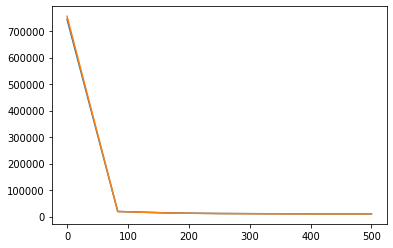

In [15]:
elbo_train_set = trainer.history["elbo_train_set"]
elbo_test_set = trainer.history["elbo_test_set"]
x = np.linspace(0, 500, (len(elbo_train_set)))
plt.plot(x, elbo_train_set)
plt.plot(x, elbo_test_set)
plt.show()

Query the imputed values via the `imputation` method of the posterior object and get common latent embedding. <br>
**Note for advanced users:** <br> imputation is an ambiguous term and there are two ways to perform imputation in scVI. The first way is to query the **mean of the negative binomial** distribution modeling the counts. This is referred to as `sample_rate` in the codebase and can be reached via the `imputation` method. The second is to query the **normalized mean of the same negative binomial** (please refer to the scVI manuscript). This is referred to as `sample_scale` in the codebase and can be reached via the `get_sample_scale` method. In differential expression for example, we of course rely on the normalized latent variable which is corrected for variations in sequencing depth.

In [16]:
full = trainer.create_posterior(trainer.model, dataset, indices=np.arange(len(dataset)),type_class=MultiPosterior)
imputed_values = full.sequential().imputation()
latent, latent_rna, latent_atac, cluster_gamma, cluster_index, batch_indices, labels = full.sequential().get_latent()

sample_latents = torch.tensor([])
sample_labels = torch.tensor([])
rna_imputation = imputed_values[0]
atac_imputation = imputed_values[3]
temp_label = []
sample_latents = torch.tensor([])
samples = torch.tensor([])
sample_labels = torch.tensor([])
if len(imputed_values) >= 3:
    temp_label = imputed_values[2]
for tensors_list in range(int(len(imputed_values[0])/256)+1):
    if temp_label.any():
        temp_samples = trainer.model.get_latents(x_rna=torch.tensor(rna_imputation[tensors_list*256:(1+tensors_list)*256,:]),
                                                x_atac=torch.tensor(atac_imputation[tensors_list*256:(1+tensors_list)*256,:]),
                                                y=torch.tensor(temp_label[tensors_list*256:(1+tensors_list)*256])) 
    else:
        temp_samples = trainer.model.get_latents(x_rna=torch.tensor(rna_imputation[tensors_list*256:(1+tensors_list)*256,:]),
                                                x_atac=torch.tensor(atac_imputation[tensors_list*256:(1+tensors_list)*256,:]),
                                                y=torch.tensor(np.zeros(256))) 
    for temp_sample in temp_samples:
        #sample_latents = torch.cat((sample_latents, temp_sample[2].float()))
        sample_latents = torch.cat((sample_latents, temp_sample[0][0].float()))
        sample_labels = torch.cat((sample_labels, torch.tensor(temp_label[tensors_list*256:(1+tensors_list)*256]).float()))

## Cell clustering
Cell clustering and merging the rare clusters with less than 10 cells

In [17]:
clust_index_gmm = trainer.model.init_gmm_params(latent)
gmm_clus_index = clust_index_gmm.reshape(-1,1)
for i in range(len(np.unique(gmm_clus_index))):
    if len(gmm_clus_index[gmm_clus_index == i]) <= 10:
        for j in range(len(np.unique(gmm_clus_index))):
            if len(gmm_clus_index[gmm_clus_index == j]) > 100:
                gmm_clus_index[gmm_clus_index == i] = j
                break
unique_gmm_clus_index = np.unique(gmm_clus_index)
for i in range(len(unique_gmm_clus_index)):
    gmm_clus_index[gmm_clus_index == unique_gmm_clus_index[i]] = i

Visualizing common latent embedding and cell clustering by scMVP

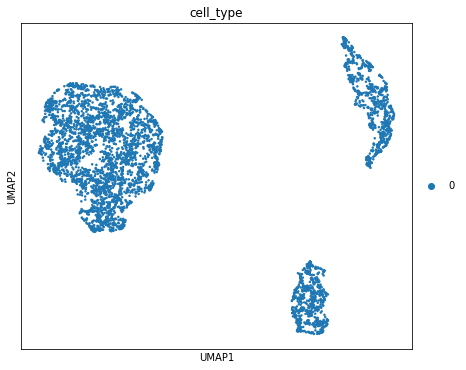

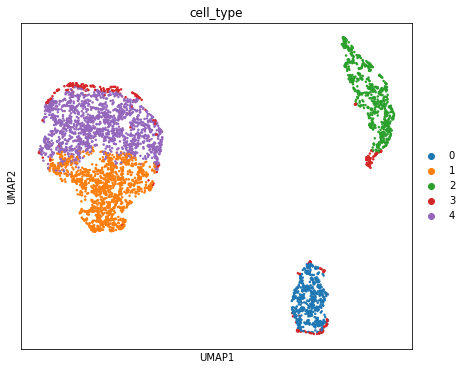

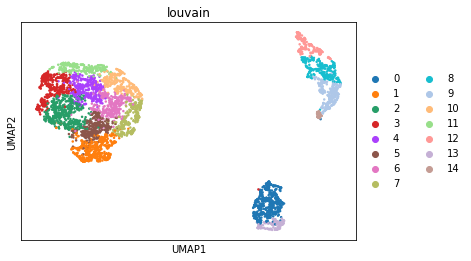

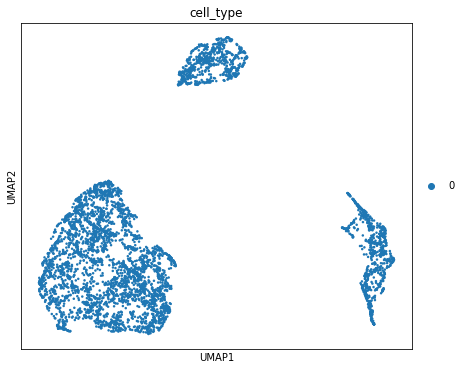

In [19]:
posterior_adata = anndata.AnnData(X=rna_imputation)
posterior_adata.obsm["X_multi_vi"] = latent
posterior_adata.obs['cell_type'] = pd.Categorical(labels)
sc.pp.neighbors(posterior_adata, use_rep="X_multi_vi", n_neighbors=15)
sc.tl.umap(posterior_adata, min_dist=0.1)
fig, ax = plt.subplots(figsize=(7, 6))
sc.pl.umap(posterior_adata, color=["cell_type"], ax=ax, show=show_plot)
# imputation labels

posterior_adata.obs['cell_type'] = pd.Categorical(clust_index_gmm)
sc.pp.neighbors(posterior_adata, use_rep="X_multi_vi", n_neighbors=15)
sc.tl.umap(posterior_adata, min_dist=0.1)

fig, ax = plt.subplots(figsize=(7, 6))
sc.pl.umap(posterior_adata, color=["cell_type"], ax=ax, show=show_plot)
sc.tl.louvain(posterior_adata)
sc.pl.umap(posterior_adata, color=['louvain']) # color by clusters

posterior_adata = anndata.AnnData(X=rna_imputation)
posterior_adata.obsm["X_multi_vi"] = sample_latents.detach().numpy()
posterior_adata.obs['cell_type'] = pd.Categorical(labels)
sc.pp.neighbors(posterior_adata, use_rep="X_multi_vi", n_neighbors=15)
sc.tl.umap(posterior_adata, min_dist=0.1)
fig, ax = plt.subplots(figsize=(7, 6))
sc.pl.umap(posterior_adata, color=["cell_type"], ax=ax, show=show_plot) # color by cell_type


## Differential gene analysis
Differential gene identification with scanpy.

/home/fusl/miniconda2/envs/scMVP/lib/python3.7/site-packages/anndata-0.7.4-py3.7.egg/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'louvain' as categorical


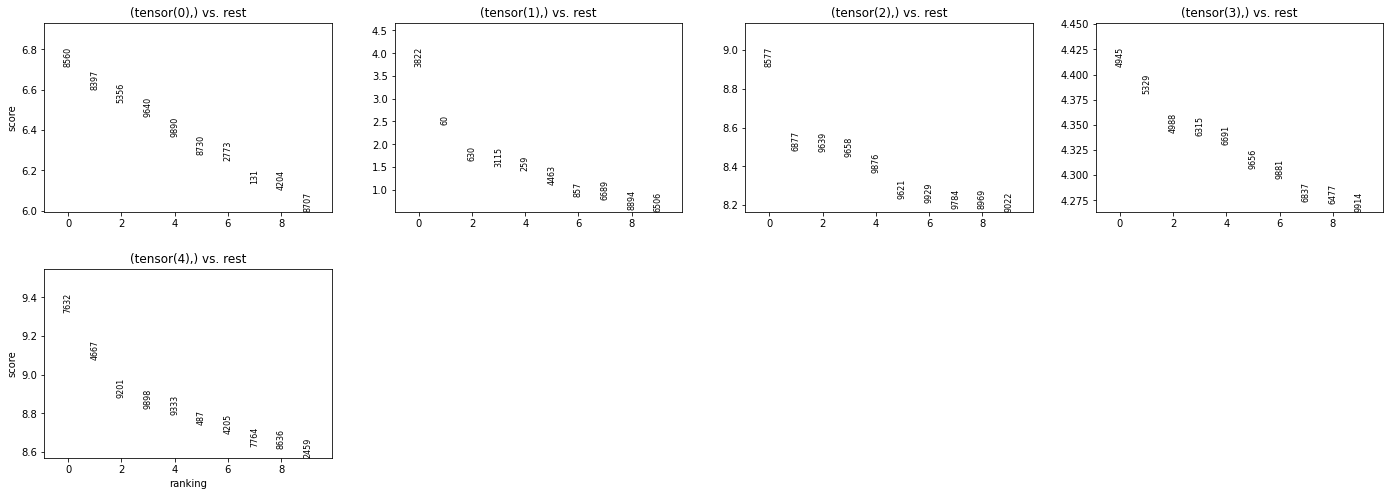

In [20]:
posterior_adata.obs['louvain'] = torch.tensor(gmm_clus_index.reshape(-1,1))
sc.tl.rank_genes_groups(posterior_adata, 'louvain')
sc.pl.rank_genes_groups(posterior_adata, n_genes=10, sharey=False)
diff_top_gene_set = posterior_adata.uns['rank_genes_groups']
diff_top_gene_set = (diff_top_gene_set['names'])
diff_top_gene_pvalue_set = posterior_adata.uns['rank_genes_groups']
diff_top_gene_pvalue_set = (diff_top_gene_pvalue_set['pvals_adj'])
diff_top_gene_foldchange_set = posterior_adata.uns['rank_genes_groups']
diff_top_gene_foldchange_set = (diff_top_gene_foldchange_set['logfoldchanges'])

Differential ATAC peaks analysis with scanpy.

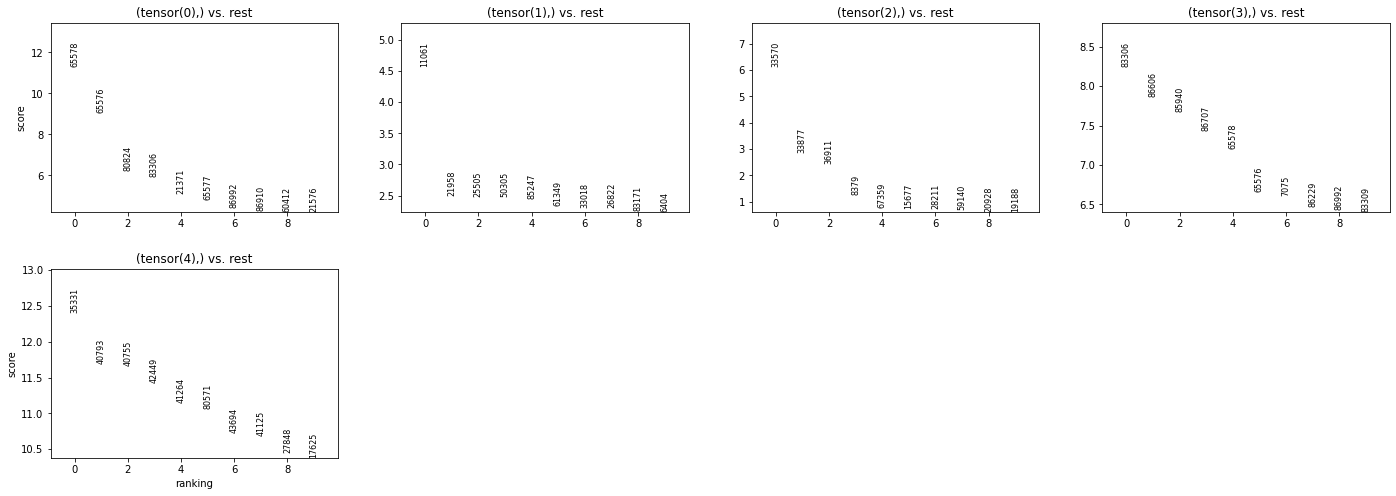

In [21]:
atac_posterior_adata = anndata.AnnData(X=atac_imputation)
atac_posterior_adata.obs['louvain'] = posterior_adata.obs['louvain']
sc.tl.rank_genes_groups(atac_posterior_adata, 'louvain',n_genes=1000)
sc.pl.rank_genes_groups(atac_posterior_adata, n_genes=10, sharey=False)
atac_diff_top_gene_set = atac_posterior_adata.uns['rank_genes_groups']
atac_diff_top_gene_set = (atac_diff_top_gene_set['names'])
atac_diff_top_gene_pvalue_set = atac_posterior_adata.uns['rank_genes_groups']
atac_diff_top_gene_pvalue_set = (atac_diff_top_gene_pvalue_set['pvals_adj'])
atac_diff_top_gene_foldchange_set = atac_posterior_adata.uns['rank_genes_groups']
atac_diff_top_gene_foldchange_set = (atac_diff_top_gene_foldchange_set['logfoldchanges'])